In [1]:
import numpy as np
import sympy
import qsymm
import kwant
from qsymm.kwant_integration import builder_to_model

sympy.init_printing(print_builtin=True)
np.set_printoptions(precision=2, suppress=True, linewidth=150)

# Graphene

In [2]:
lat = kwant.lattice.honeycomb(norbs=[1, 1])
sym = kwant.TranslationalSymmetry(lat.vec((1, 0)), lat.vec((0, 1)))

bulk = kwant.Builder(sym)
bulk[ [lat.a(0, 0), lat.b(0, 0)] ] = 0
bulk[lat.neighbors()] = 1
wrapped = kwant.wraparound.wraparound(bulk).finalized()
kwant.wraparound.plot_2d_bands(wrapped);

/home/tinkerer/.conda/envs/new_dev/lib/python3.6/site-packages/kwant/wraparound.py:458: RuntimeWarning: Kwant's plotting functions have
the side effect of selecting the matplotlib backend. To avoid this warning,
import matplotlib.pyplot, matplotlib.backends or call matplotlib.use().
  fig_size=fig_size, ax=ax)


<Figure size 640x480 with 1 Axes>

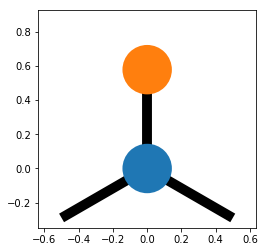

In [3]:
kwant.plot(bulk);

In [5]:
ham = builder_to_model(bulk)

In [10]:
hex_group_2D = qsymm.groups.hexagonal()
print(len(hex_group_2D))

48


In [26]:
sham = ham.tosympy(nsimplify=True)

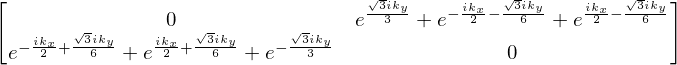

In [24]:
sham

In [20]:
mham = ham.tomodel(nsimplify=True)

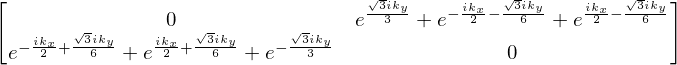

In [28]:
sham

In [29]:
sg, cg = qsymm.symmetries(ham, hex_group_2D)
print(len(sg))
print(set(sg) == qsymm.groups.hexagonal())
print(cg)

/home/tinkerer/.conda/envs/new_dev/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:1099: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(concatenate(arr_rows, axis=0))


48
True
[]


In [30]:
sg, cg = qsymm.symmetries(mham, hex_group_2D)
print(len(sg))
print(set(sg) == qsymm.groups.hexagonal())
print(cg)

48
True
[]


# Wire with chiral symmetry

Kwant is used to generate the tight-binding model for a finite cross section wire

In [ ]:
import kwant
import matplotlib.pyplot as plt
import wire.funcs as funcs

Define symmetry candidates, in 1D the only nontrivial space-group element is inversion, besides add both TR and PH.

The $\mathbf{k\cdot p}$ Hamiltonian is discretized with a lattice constant of $a = 10$ nm. The wire and shell diameter of $r_1 = 15$ nm, $r_2 = 30$ nm used here allow the calculation in about 30 seconds, the example shown in the paper uses $r_1 = 25$ nm, $r_2 = 40$ nm and takes about 10 minutes.

The electric field is in the $z$ direction all along.

In [ ]:
candidates = {qsymm.PointGroupElement(np.eye(1), True, False, None),
              qsymm.PointGroupElement(np.eye(1), False, True, None),
              qsymm.PointGroupElement(-np.eye(1), False, False, None)
             }
candidates = qsymm.groups.generate_group(candidates)
len(candidates)

r1=15
r2=30
Vz = lambda *pos: pos[2]
color = lambda site: ('w' if (np.dot(site.pos, site.pos)) < r1**2 else 'r')

Make system with mirror symmetry and magnetic field in $x$ direction.

In [ ]:
syst_pars = dict(a=10, angle=0, coverage_angle=100, r1=r1, r2=r2, shape='circle',
                 A_correction=True, with_shell=True, rotate_spin_orbit=False)

lead = funcs.make_lead(**syst_pars)

kwant.plot(lead, site_color = color);

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

The system has the full 8-element symmetry group.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Add magnetic field in $z$ direction.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0.1, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

The symmetry group still contains an effective time-reversal symmetry $M_y T$

In [ ]:
%time symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Add magnetic field in $y$ direction.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0.1, B_z=0, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

The symmetry group only contains $C_{2z} T$, which doesn't prevent band-tilting.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Move shell such that it breaks $M_y$

In [ ]:
syst_pars = dict(a=10, angle=45, coverage_angle=100, r1=r1, r2=r2, shape='circle',
                 A_correction=True, with_shell=True, rotate_spin_orbit=False)

lead = funcs.make_lead(**syst_pars)

kwant.plot(lead, site_color = color);

Field only along the wire.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

Mirror symmetry $M_x$ is preserved.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Add field in $z$ direction.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0.1, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

All symmetry is broken except for particle-hole.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]